In [1]:
import torch
import math
from torch import nn
from tqdm import tqdm
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.cm as cm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from umap import UMAP
import time
from datetime import timedelta
import torch_optimizer as optim


from abc import abstractmethod
from typing import List, Any, Tuple, Dict
from torch import Tensor

# only import if cuml is installed
try:
    from cuml.accel import install
    install()
except ImportError:
    print("Cuml not installed, using CPU for umap and sklearn")

from utils import RepresentationLayer, DGD, ConvDecoder, LatentSpaceVisualizer, GaussianMixture, GMMInitializer, plot_training_losses, plot_images, plot_gmm_images, plot_gmm_samples

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")

if device.type == 'cuda':
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Allocated memory: {torch.cuda.memory_allocated(device)/1024**2} MB")
    print(f"Reserved memory: {torch.cuda.memory_reserved(device)/1024**2} MB")
    print(f"Total memory: {torch.cuda.get_device_properties(device).total_memory/1024**2} MB")

RANDOM_STATE = 0
use_small_dataset = True

print('Using device:', device)

/home/asp/miniforge3/envs/rapids-25.04/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuML: Installed accelerator for sklearn.
cuML: Installed accelerator for umap.
cuML: Successfully initialized accelerator.
PyTorch CUDA version: 12.6
PyTorch version: 2.7.0+cu126
Number of CUDA devices: 1
Current CUDA device: 0
Allocated memory: 0.0 MB
Reserved memory: 0.0 MB
Total memory: 7816.5625 MB
Using device: cuda:0


Using small dataset, adjusted batch size: 128
Train dataset: 6000 (10% of total: 60000)
Test dataset: 1000 (10% of total: 10000)
Image shape: torch.Size([1, 28, 28])
Image size: 784
Plotting 20 images.


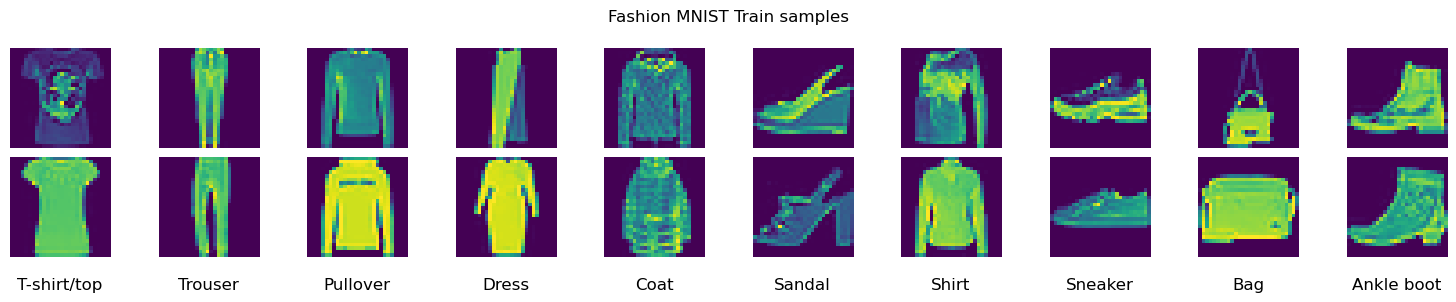

Plotting 20 images.


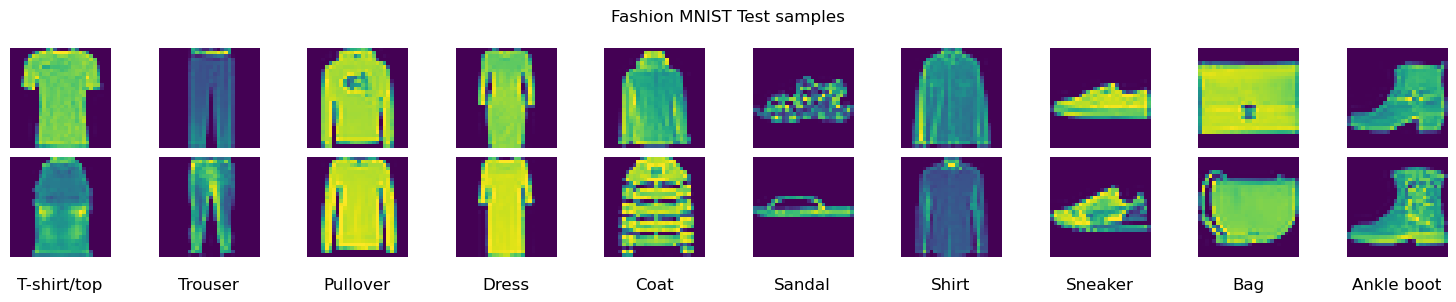

In [2]:
# Load the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

class IndexedDataset(Dataset):
    def __init__(self, dataset, use_subset=False, subset_fraction=0.1):
        """
        Wrap a dataset with indices
        
        Parameters:
        ----------
        dataset: The original dataset
        use_subset: Whether to use only a subset of the data
        subset_fraction: The fraction of data to use if use_subset is True
        """
        self.dataset = dataset
        
        if use_subset:
            # Create a subset of indices (10% by default)
            total_size = len(dataset)
            subset_size = int(total_size * subset_fraction)
            
            # Create random indices ensuring we get samples from all classes
            all_indices = list(range(total_size))
            np.random.shuffle(all_indices)
            self.indices = all_indices[:subset_size]
        else:
            # Use all indices
            self.indices = list(range(len(dataset)))
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        # Map the index to the original dataset index
        orig_index = self.indices[index]
        data, target = self.dataset[orig_index]
        return orig_index, data, target

# Create datasets with the option to use only a subset
indexed_train_dataset = IndexedDataset(train_dataset, use_subset=use_small_dataset)
indexed_test_dataset = IndexedDataset(test_dataset, use_subset=use_small_dataset)

# Adjust batch size if using a small dataset
batch_size = 128
if use_small_dataset:
    # Use smaller batch size for small datasets
    batch_size = min(batch_size, max(32, len(indexed_train_dataset) // 10))
    print(f"Using small dataset, adjusted batch size: {batch_size}")

train_loader = DataLoader(indexed_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(indexed_test_dataset, batch_size=batch_size, shuffle=True)

# Print dataset info
print('Train dataset:', len(indexed_train_dataset), 
      f'({"10% of " if use_small_dataset else ""}total: {len(train_dataset)})')
print('Test dataset:', len(indexed_test_dataset), 
      f'({"10% of " if use_small_dataset else ""}total: {len(test_dataset)})')

# Print shape of an image
print('Image shape:', train_dataset[0][0].shape)
# Print total number of pixels in an image
print('Image size:', train_dataset[0][0].numel())

all_labels = torch.tensor([train_dataset[i][1] for i in indexed_train_dataset.indices], device=device)

# Get a batch of images and labels
batch_train = next(iter(train_loader))
indices_train, images_train, labels_train = batch_train

batch_test = next(iter(test_loader))
indices_test, images_test, labels_test = batch_test

# Plot the images with their labels
plot_images(images_train, labels_train, 'Fashion MNIST Train samples', epoch=None, cmap='viridis')
plot_images(images_test, labels_test, 'Fashion MNIST Test samples', epoch=None, cmap='viridis')

Decoder parameters: 5,329 (0.01M)
Train representation parameters: 30,000 (0.03M)
Test representation parameters: 5,000 (0.01M)
Total trainable parameters: 40,329 (0.04M)

Parameter distribution:
Decoder: 15.1%
Train rep: 84.9%


/home/asp/Downloads/HeaDS/ImageDGD/utils/gmm.py:752: UserWarning: EM algorithm did not converge. Try increasing max_iter or lowering tol.
  warnings.warn("EM algorithm did not converge. Try increasing max_iter or lowering tol.", UserWarning)
/home/asp/Downloads/HeaDS/ImageDGD/utils/gmm.py:689: UserWarning: EM algorithm did not converge. Try increasing max_iter or lowering tol.
  warnings.warn("EM algorithm did not converge. Try increasing max_iter or lowering tol.", UserWarning)


Epoch 1/500 [0:00:17] - ETA: 2:24:05: Train Loss: 74.8152, Test Loss: 64.5763, Recon Train: 83.8951, Recon Test: 73.8268, GMM Train: -9.0800, GMM Test: -9.2505
Unused keyword parameter: random_state during cuML estimator initialization


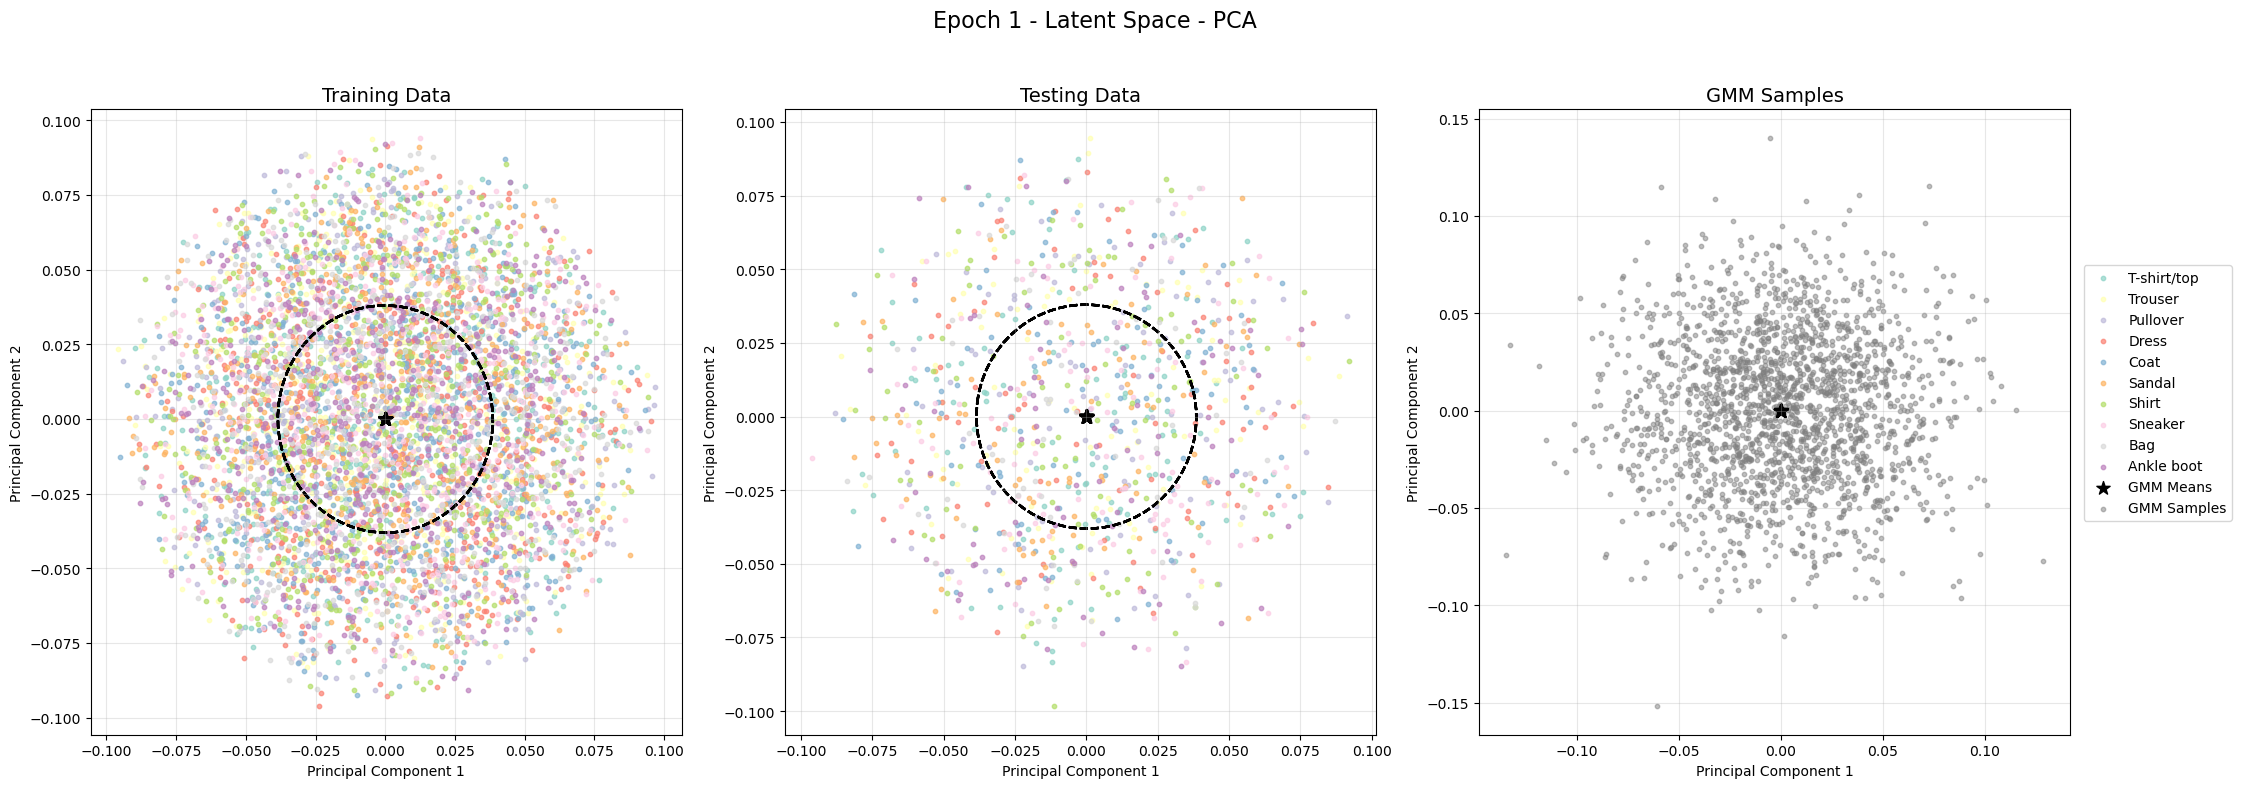

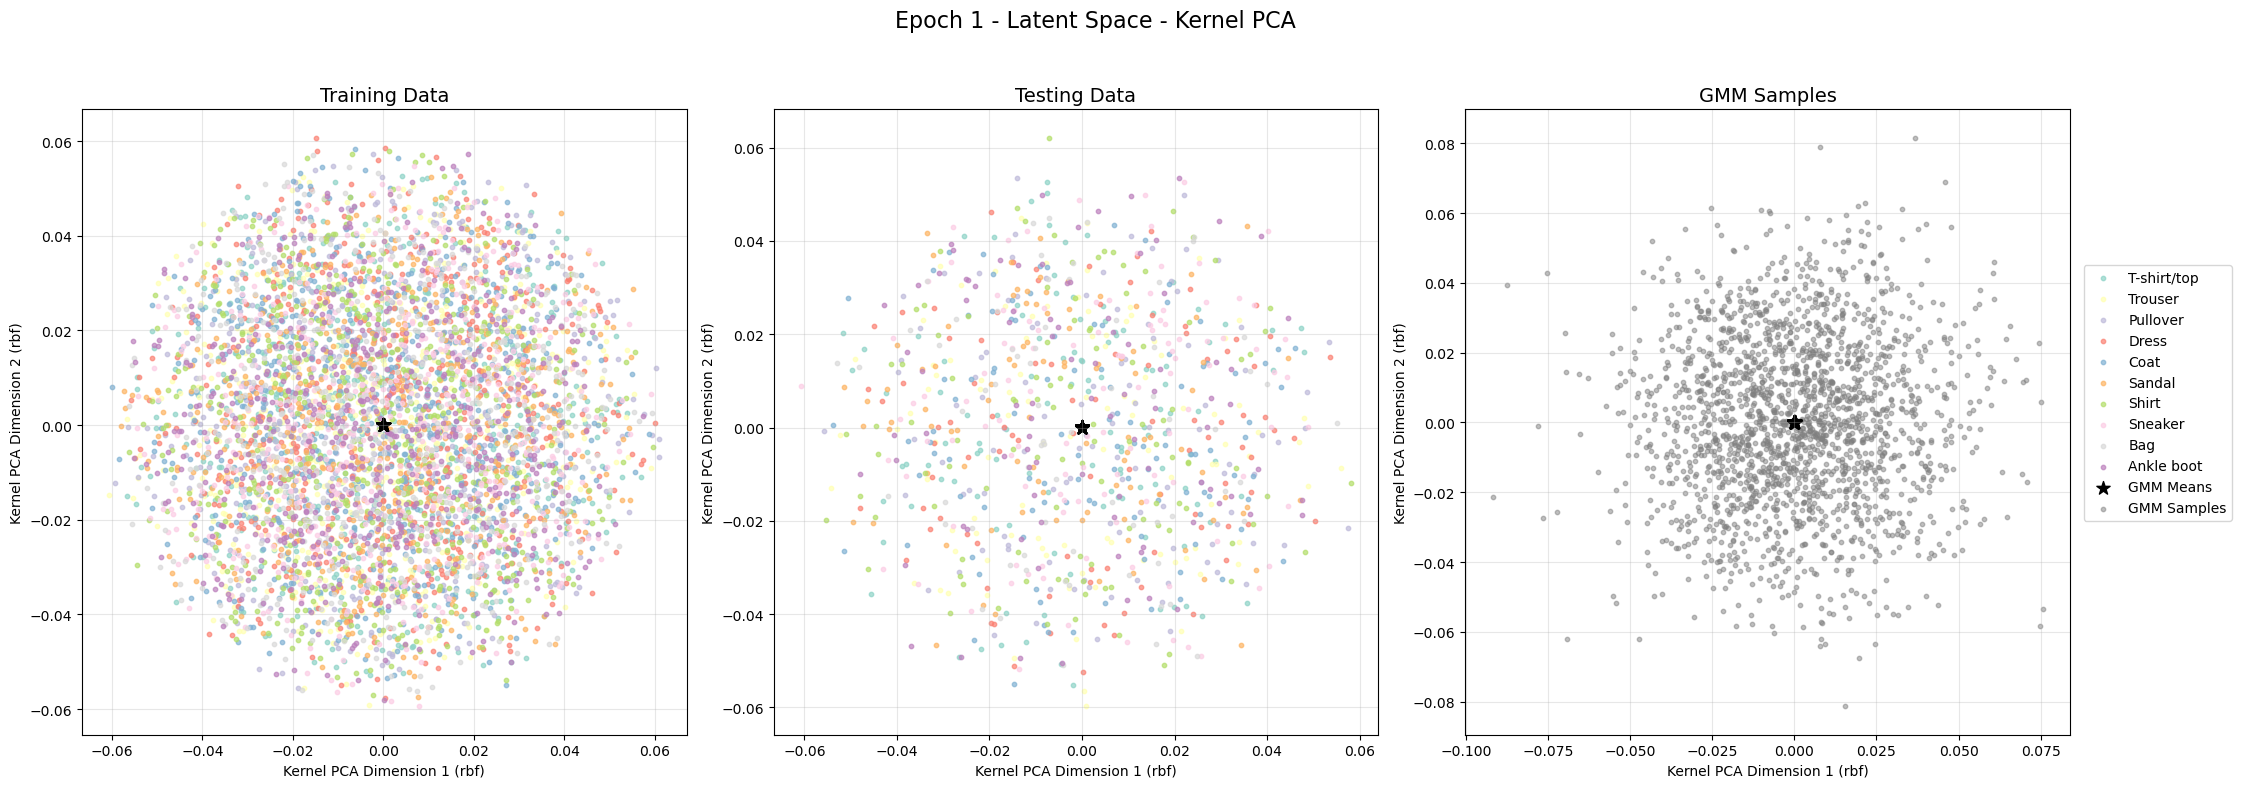

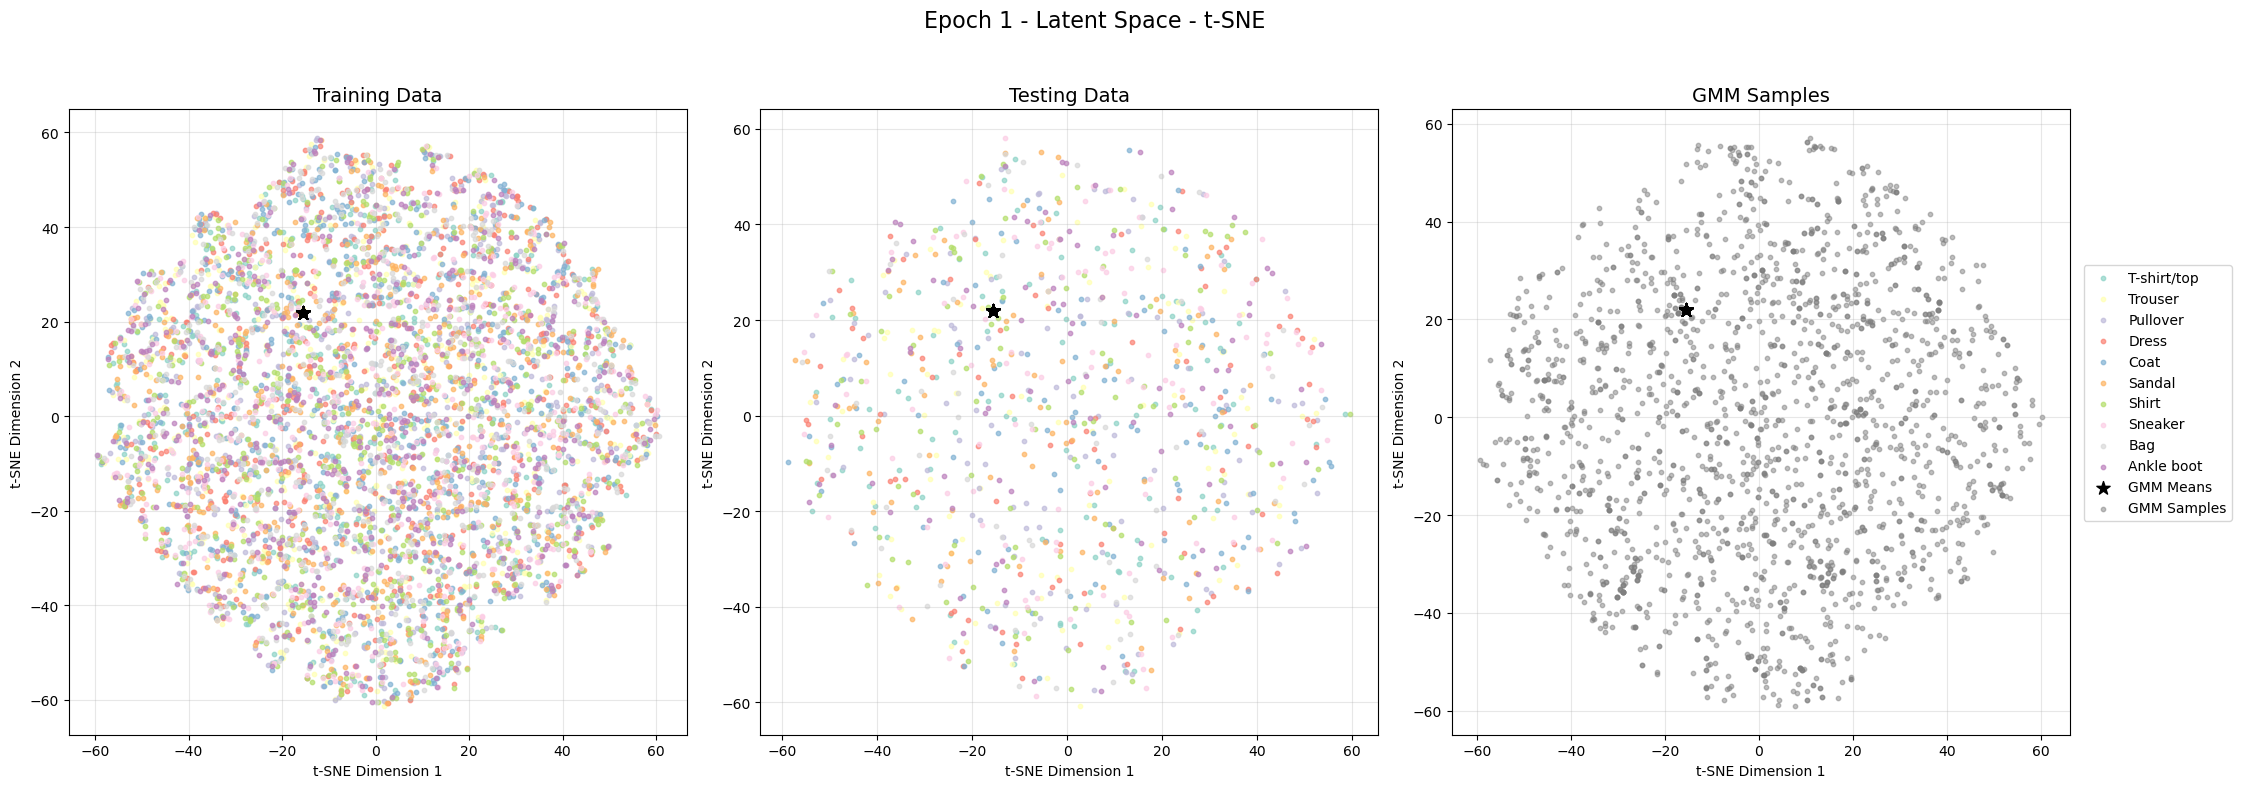

build_algo set to brute_force_knn because random_state is given


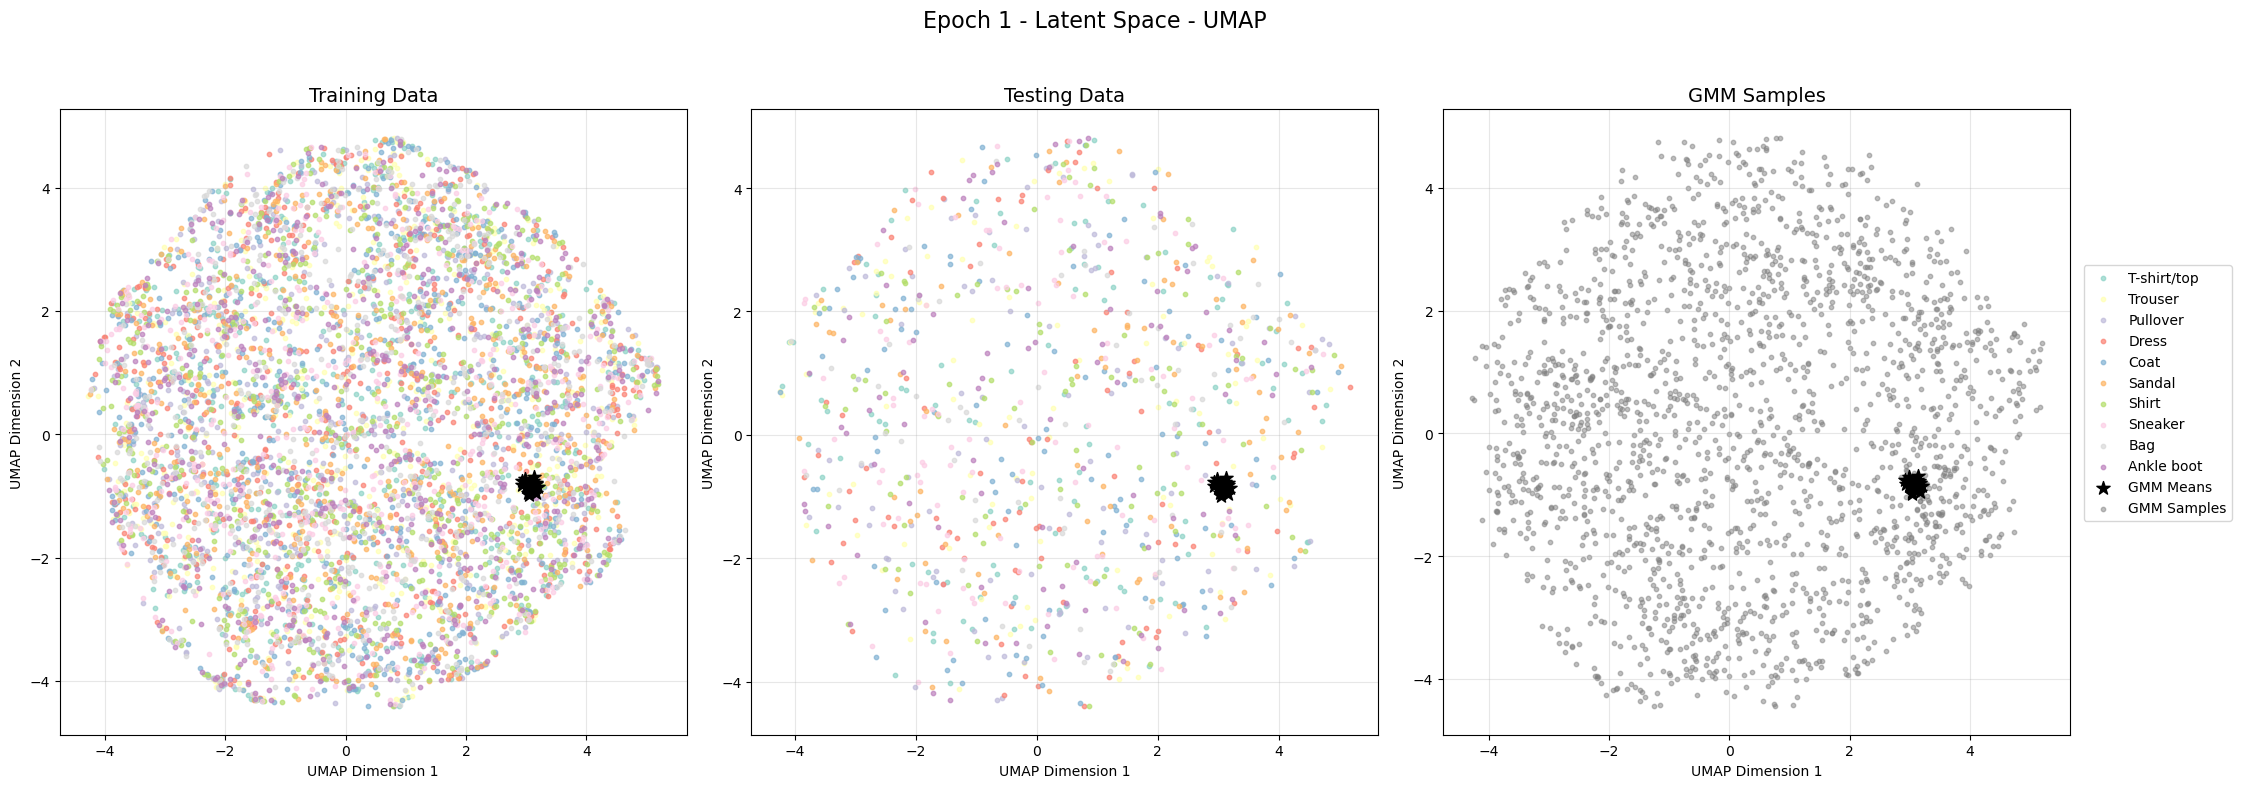

Epoch 2/500 [0:00:17] - ETA: 2:25:22: Train Loss: 60.9435, Test Loss: 58.0349, Recon Train: 70.1559, Recon Test: 67.4140, GMM Train: -9.2123, GMM Test: -9.3791
Epoch 3/500 [0:00:17] - ETA: 2:24:13: Train Loss: 59.8507, Test Loss: 57.4871, Recon Train: 69.1998, Recon Test: 66.9982, GMM Train: -9.3491, GMM Test: -9.5111
Epoch 4/500 [0:00:16] - ETA: 2:22:01: Train Loss: 59.3221, Test Loss: 57.3019, Recon Train: 68.8045, Recon Test: 66.9414, GMM Train: -9.4824, GMM Test: -9.6396
Epoch 5/500 [0:00:16] - ETA: 2:20:00: Train Loss: 59.0431, Test Loss: 57.1494, Recon Train: 68.6546, Recon Test: 66.9140, GMM Train: -9.6115, GMM Test: -9.7646


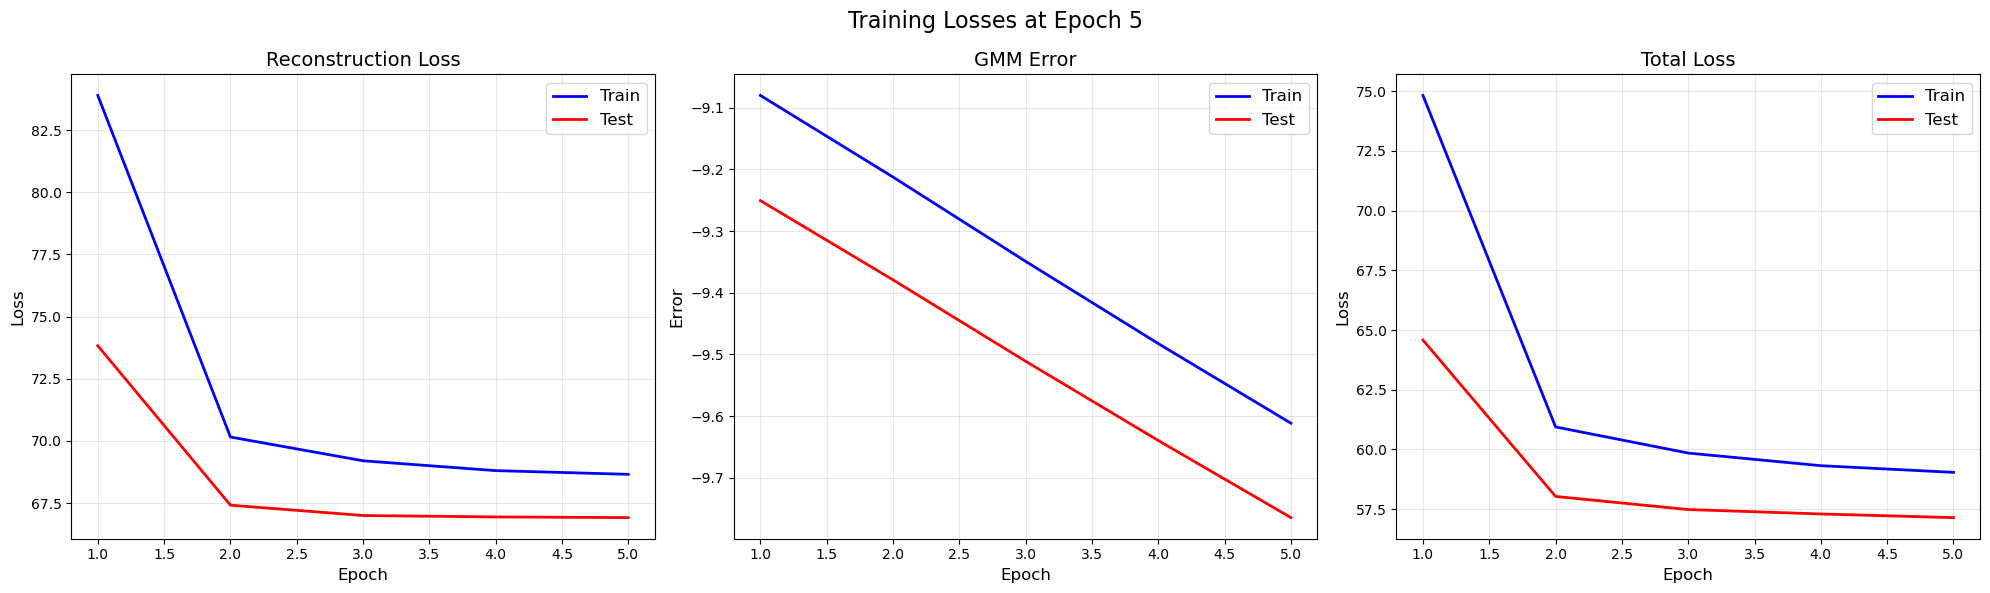

Plotting 20 images.


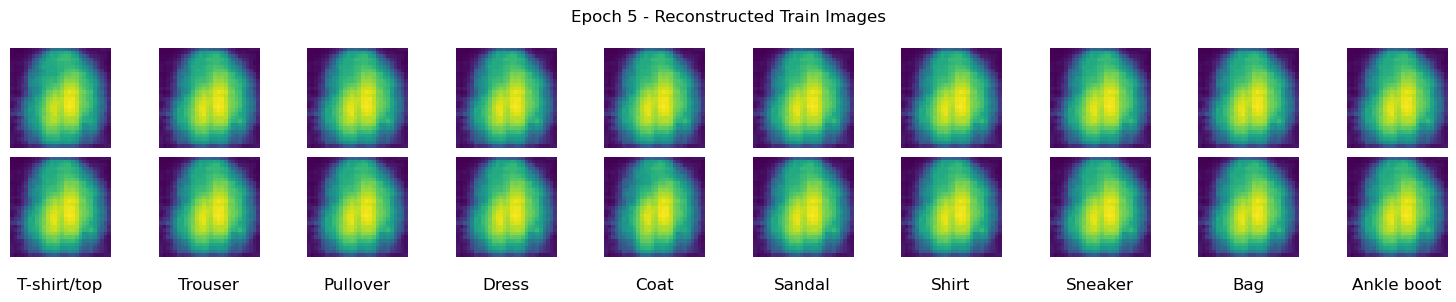

Plotting 20 images.


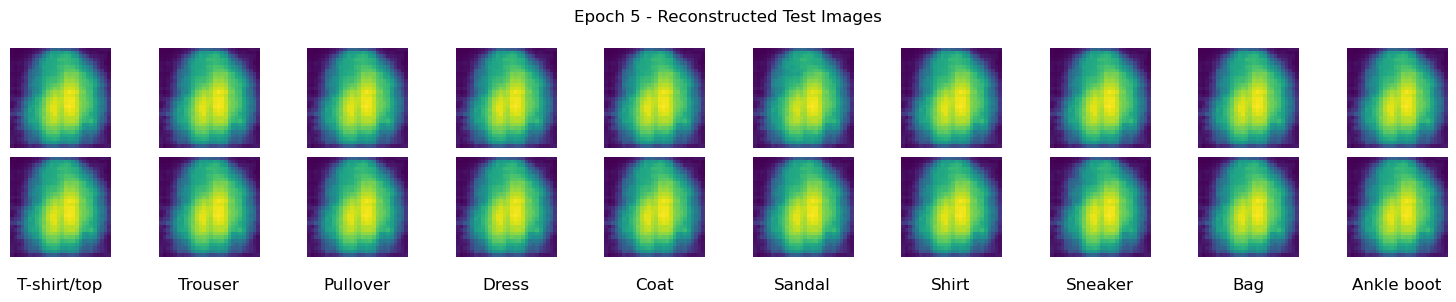

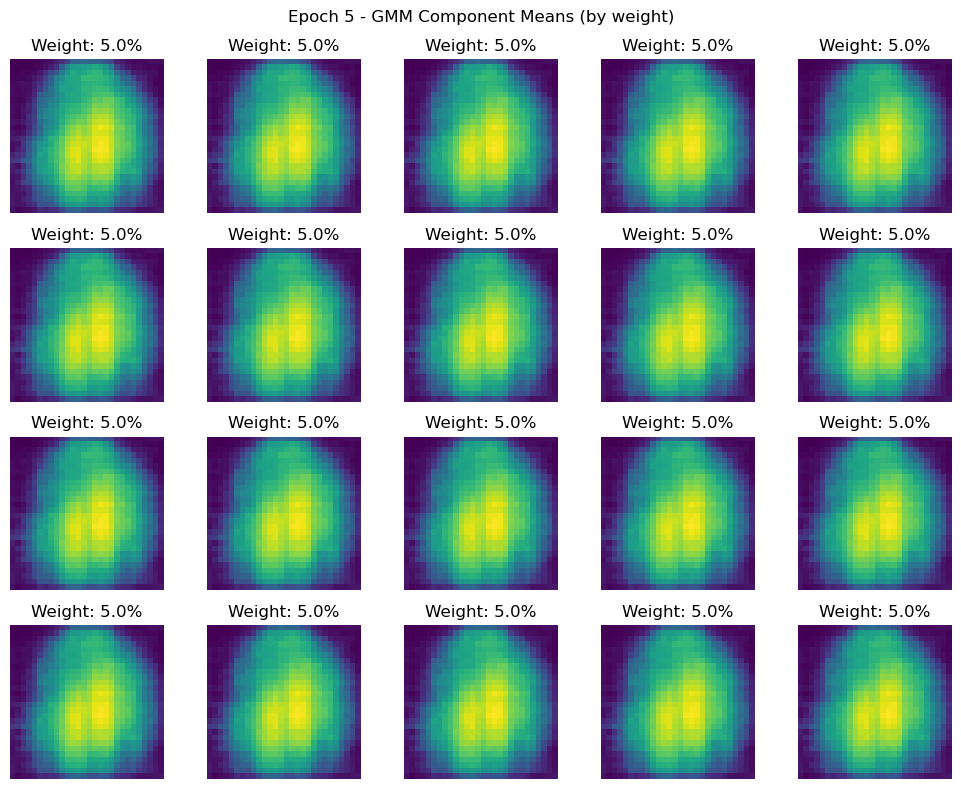

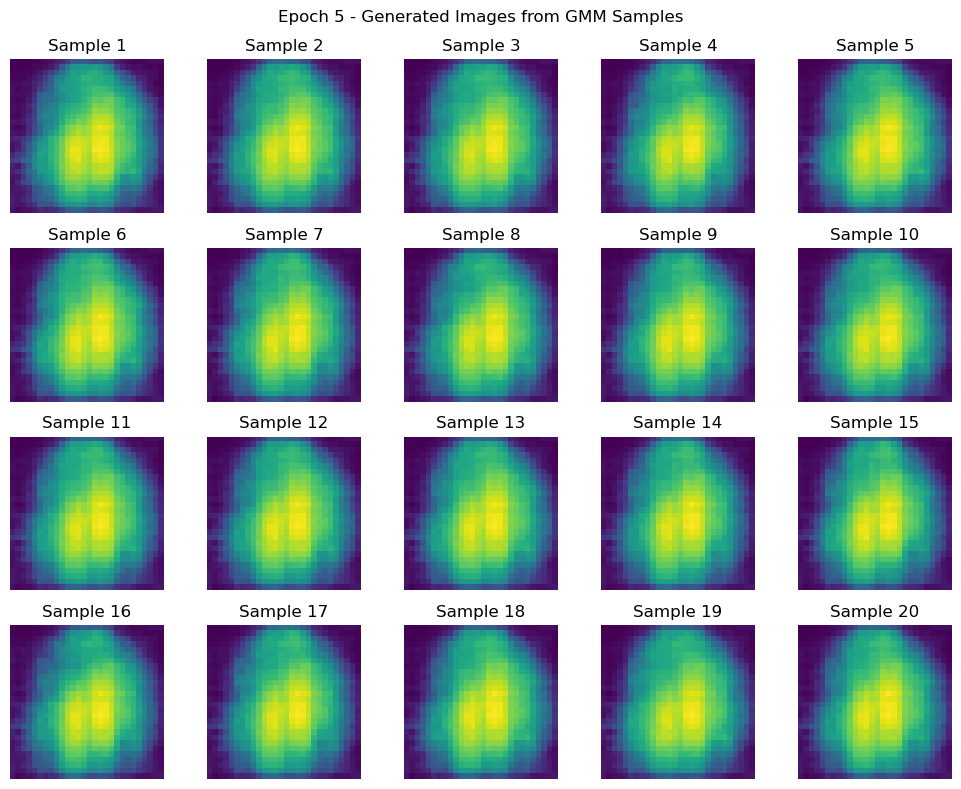

Unused keyword parameter: random_state during cuML estimator initialization


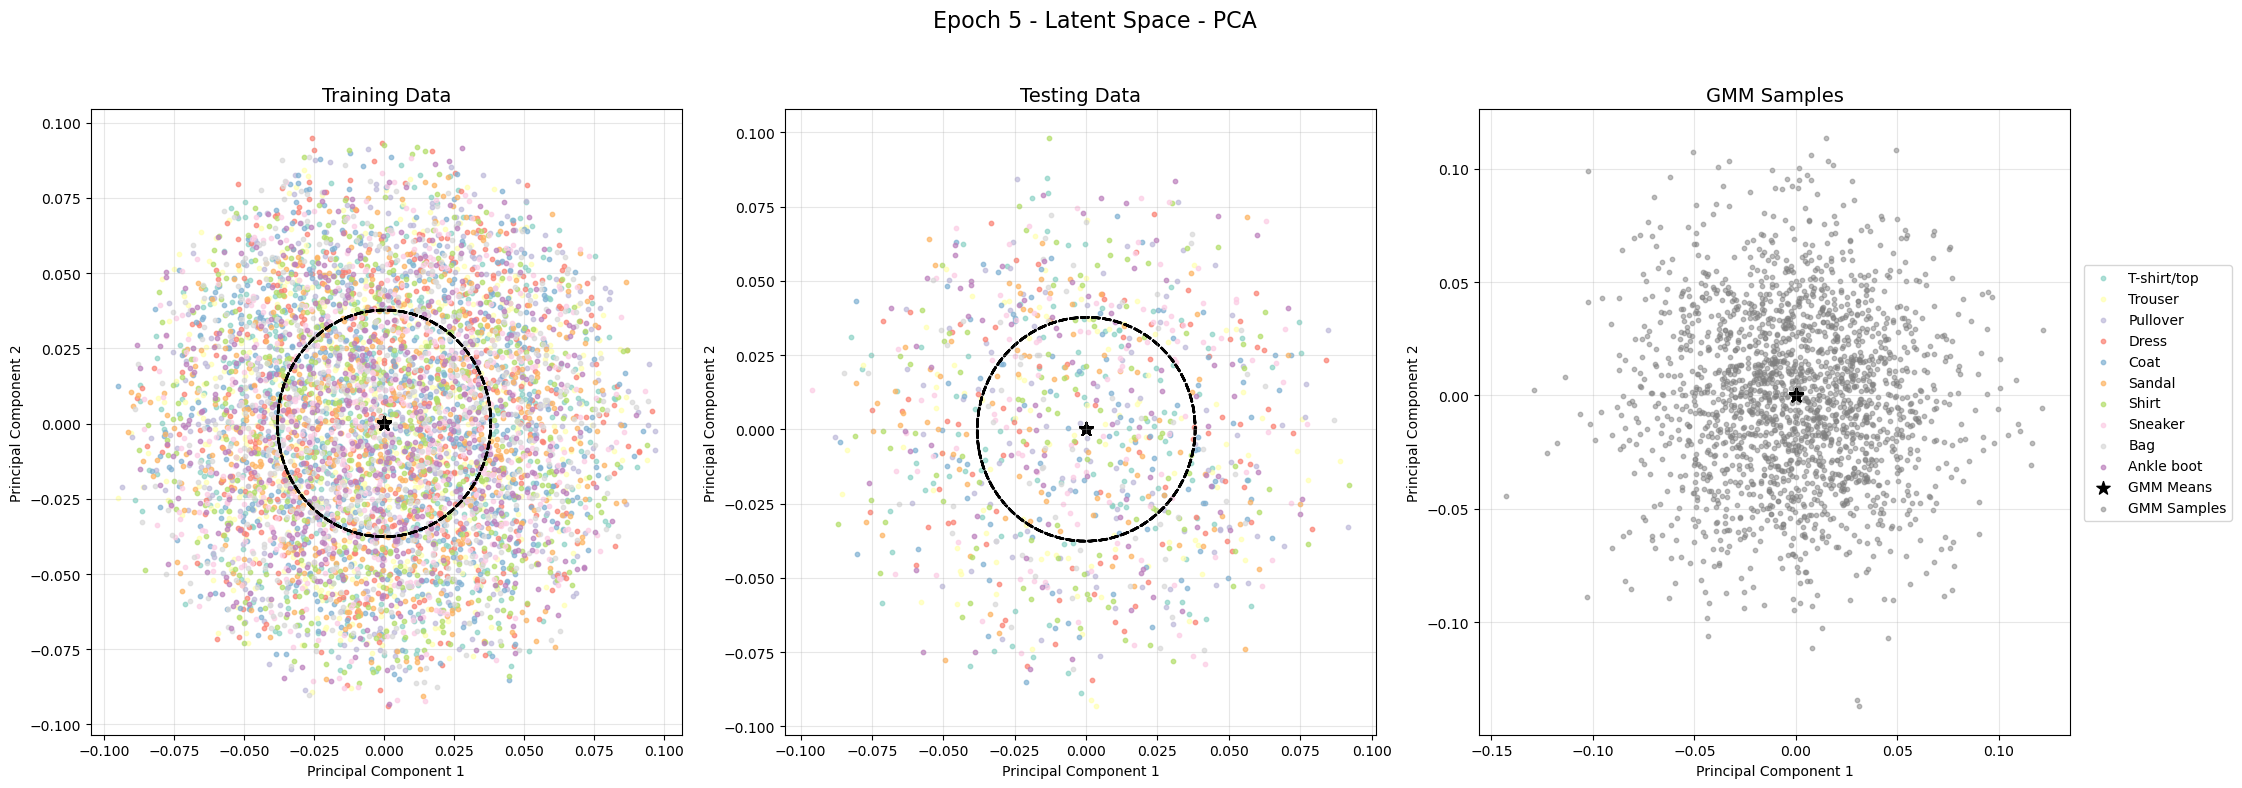

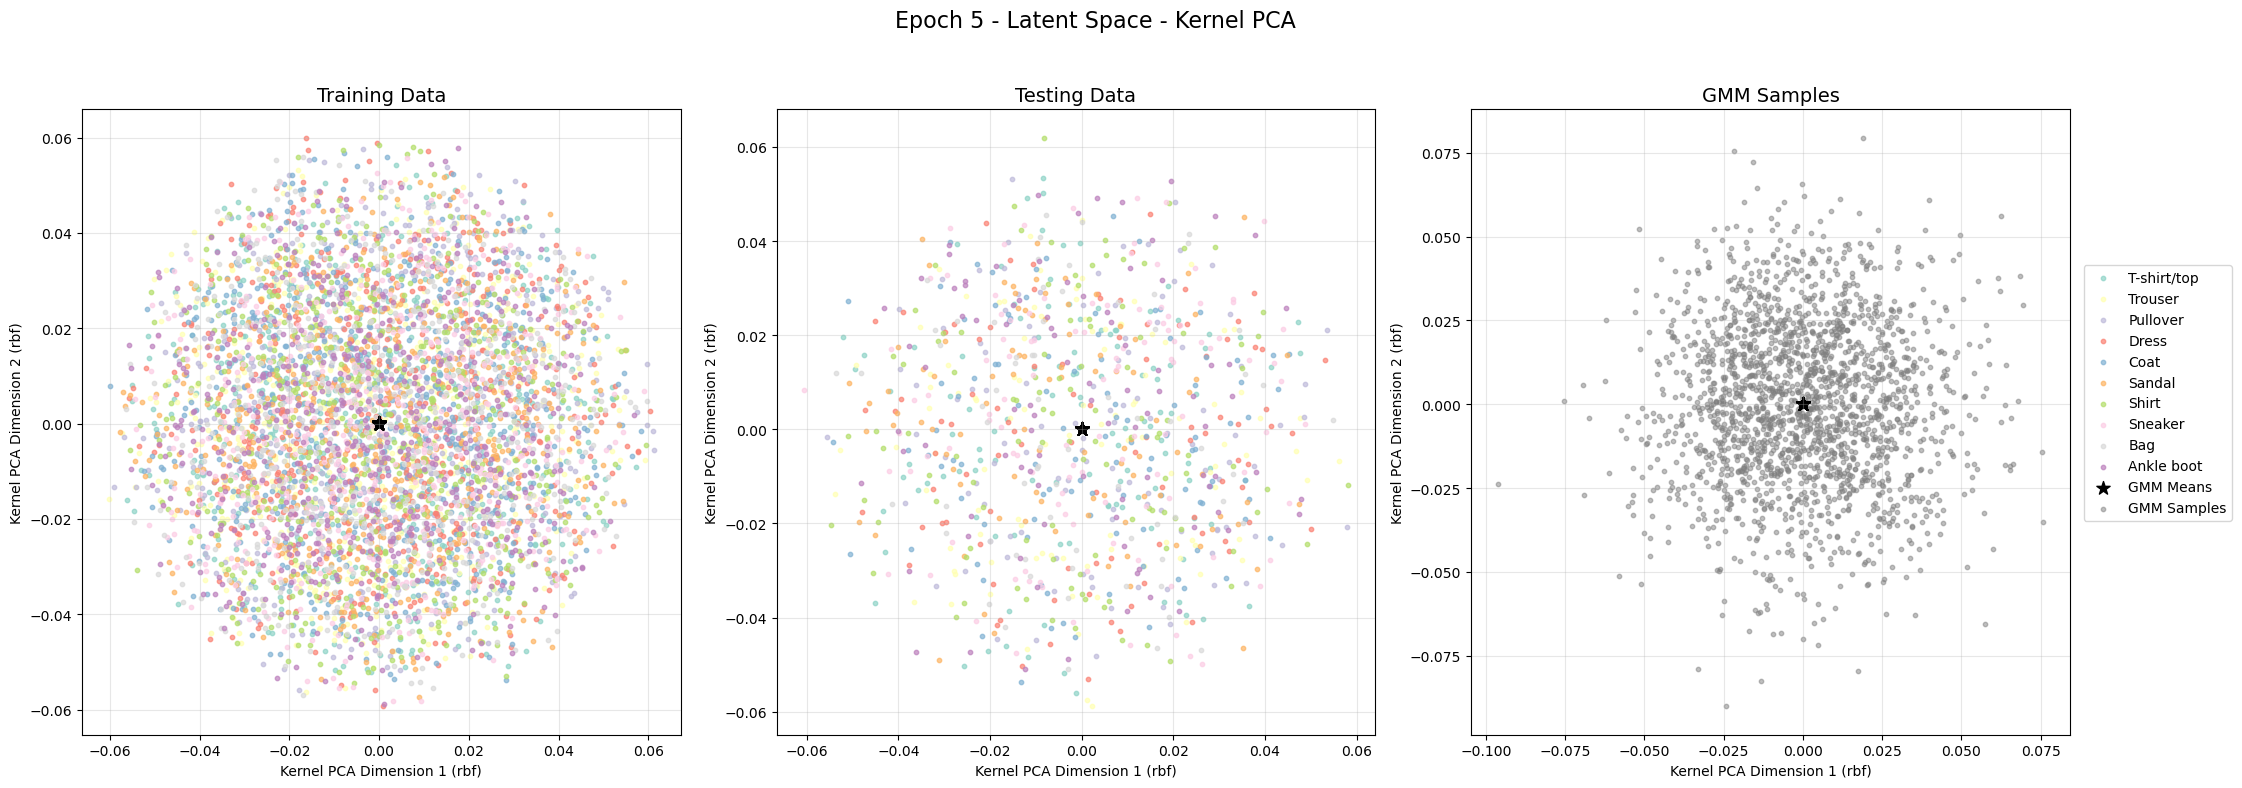

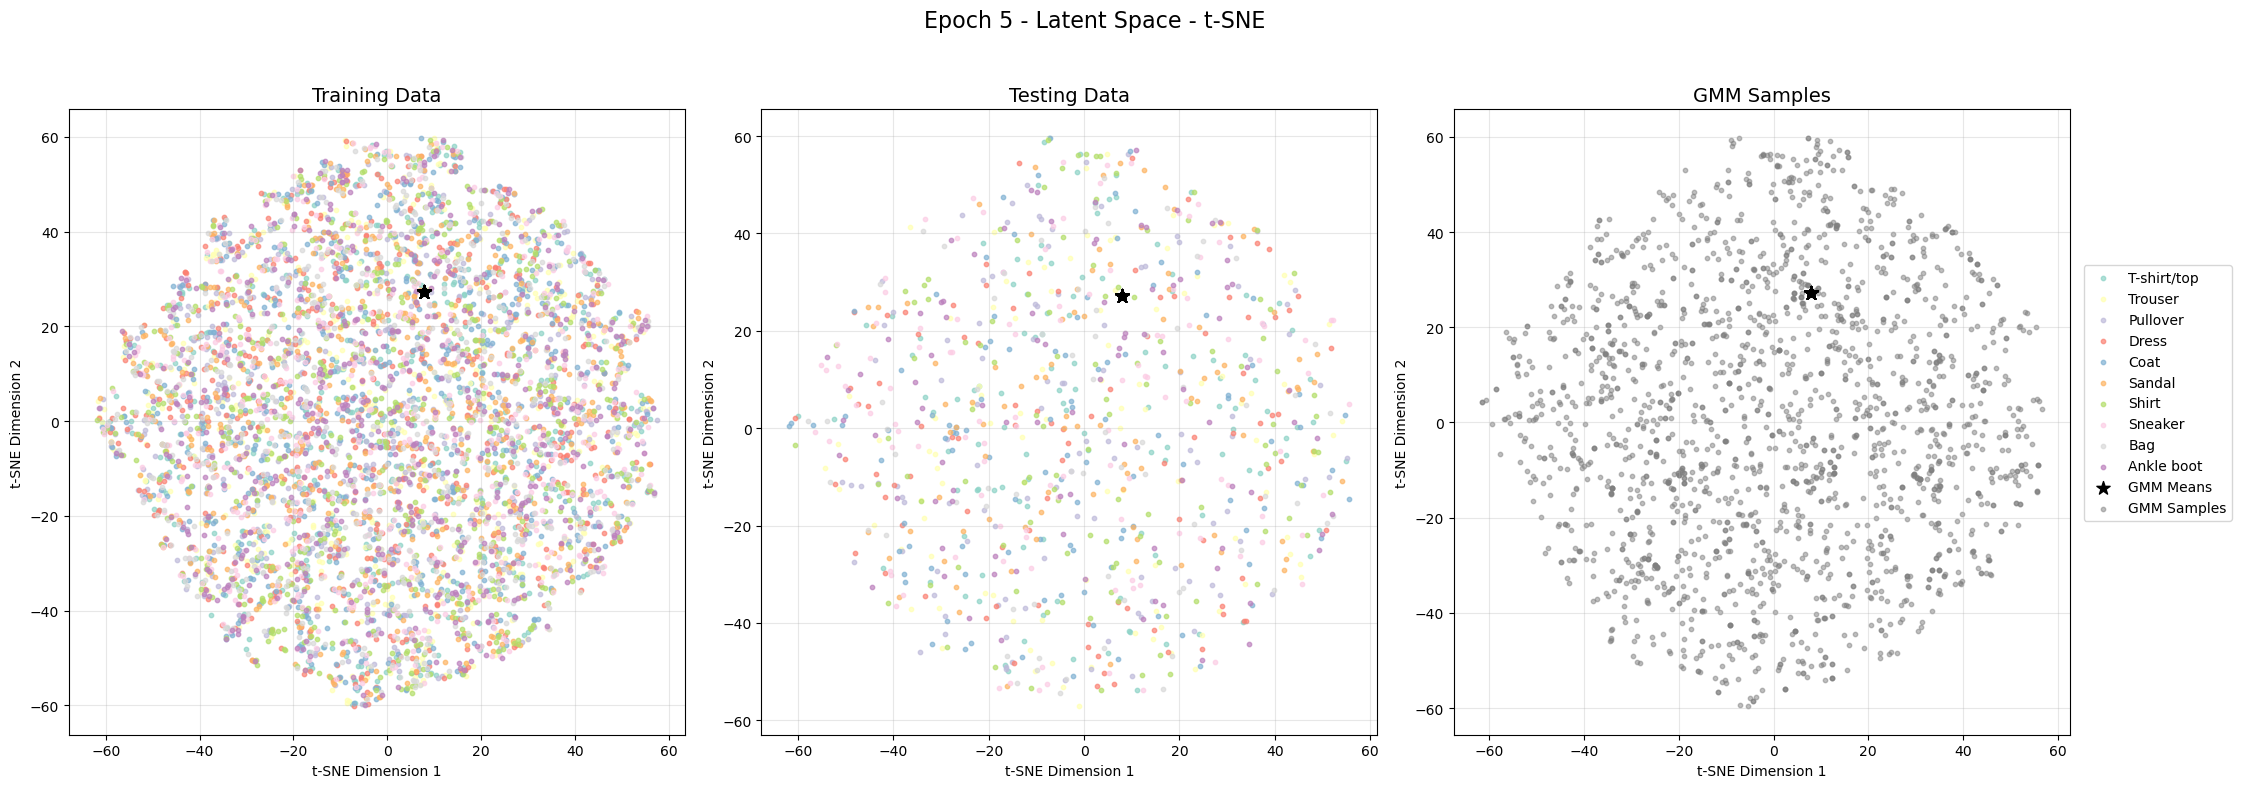

build_algo set to brute_force_knn because random_state is given


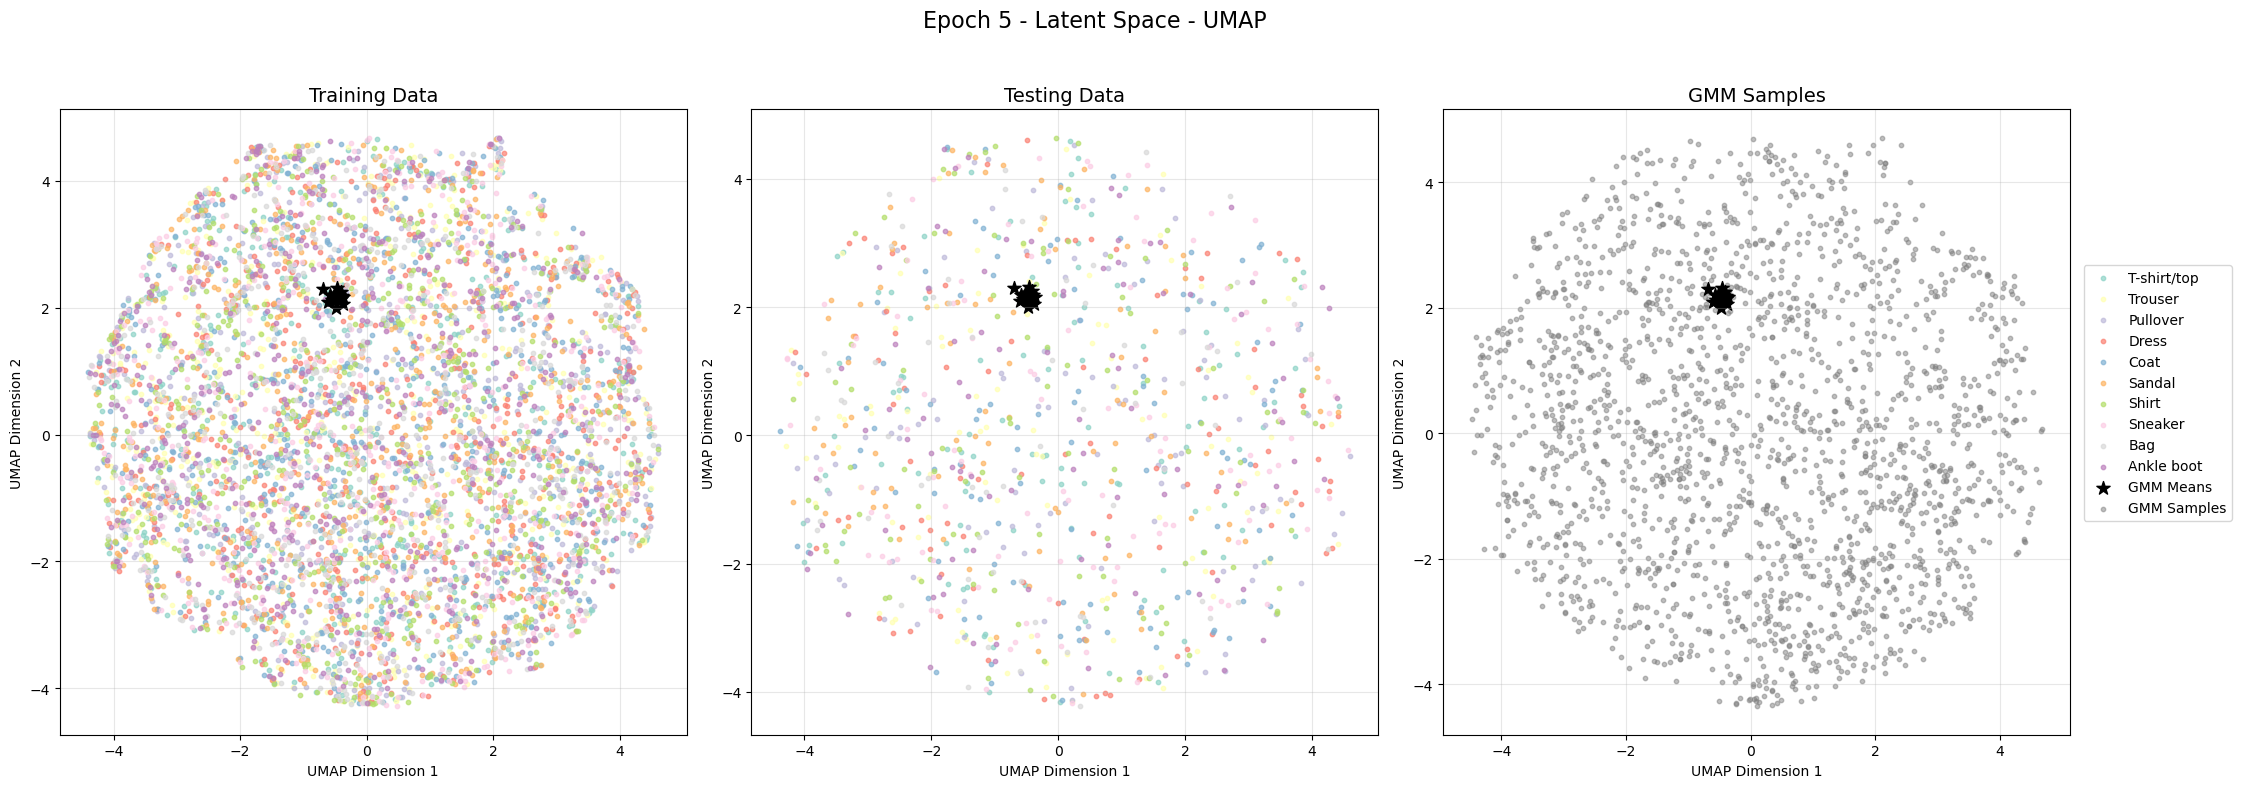

Epoch 6/500 [0:00:16] - ETA: 2:19:04: Train Loss: 58.7135, Test Loss: 56.8491, Recon Train: 68.4500, Recon Test: 66.7353, GMM Train: -9.7365, GMM Test: -9.8863


KeyboardInterrupt: 

In [3]:
def train_model(train_loader, test_loader, decoder_model, optimizers, 
                          test_rep, n_epochs, first_epoch_gmm=1, 
                          refit_gmm_interval=None, lambda_gmm=1.0, 
                          metrics_list=None, device='cuda', plot_interval=10):
    """
    Training loop for the decoder-GMM model with separate train and test representation layers.
    """
    model_optimizer, rep_optimizer, testrep_optimizer = optimizers
    
    train_losses = []
    test_losses = []
    gmm_train_losses = []
    gmm_test_losses = []
    recon_train_losses = []
    recon_test_losses = []
    
    start_time = time.time()
    epoch_times = []  # Track epoch times for better ETA calculation
    
    # Get references from the decoder model
    model = decoder_model.decoder
    rep = decoder_model.rep_layer
    gmm = decoder_model.gmm
    

    
    for epoch in range(1, n_epochs + 1):
        epoch_start_time = time.time()
        
        train_losses.append(0)
        test_losses.append(0)
        gmm_train_losses.append(0)
        gmm_test_losses.append(0)
        recon_train_losses.append(0)
        recon_test_losses.append(0)

        # Initialize or refit GMM
        if epoch == 1 and gmm is not None:
            with torch.no_grad():
                representations = rep.z.detach()
                gmm.fit(representations, max_iter=1)
        elif epoch == first_epoch_gmm + 1 and gmm is not None:
            with torch.no_grad():
                representations = rep.z.detach()
                gmm.fit(representations, max_iter=1000)
        elif epoch > first_epoch_gmm + 1 and gmm is not None:
            with torch.no_grad():
                representations = rep.z.detach()
                if refit_gmm_interval and epoch % refit_gmm_interval == 0:
                    gmm.fit(representations, max_iter=1000)
                else:
                    gmm.fit(representations, max_iter=100, warm_start=True)

        
        # Training loop
        model.train()
        rep_optimizer.zero_grad()
        
        for i, (index, x, labels_batch) in enumerate(train_loader):
            model_optimizer.zero_grad()
            
            x, index = x.to(device), index.to(device)
            
            # Calculate loss
            if epoch >= first_epoch_gmm and gmm is not None:
                # Using GMM
                z = rep(index)
                y = model(z)
                recon_loss = F.mse_loss(y, x, reduction='sum')
                gmm_error = -lambda_gmm * torch.sum(gmm.score_samples(z))
                loss = recon_loss + gmm_error
            else:
                # Without GMM
                z = rep(index)
                y = model(z)
                recon_loss = F.mse_loss(y, x, reduction='sum')
                loss = recon_loss
                gmm_error = torch.tensor(0.0).to(device)
            
            # Backpropagation
            loss.backward()
            model_optimizer.step()
            
            # Track losses
            train_losses[-1] += loss.item()
            recon_train_losses[-1] += recon_loss.item()
            if epoch >= first_epoch_gmm:
                gmm_train_losses[-1] += gmm_error.item()
        
        rep_optimizer.step()


        
        
        
        # Testing loop
        model.eval()
        testrep_optimizer.zero_grad()  # Zero out test rep gradients
        
        for i, (index, x, _) in enumerate(test_loader):
            x, index = x.to(device), index.to(device)
            
            # Calculate loss
            if epoch >= first_epoch_gmm and gmm is not None:
                # Using GMM
                z = test_rep(index)  # Use test_rep
                y = model(z)
                recon_loss = F.mse_loss(y, x, reduction='sum')
                gmm_error = -lambda_gmm * torch.sum(gmm.score_samples(z))
                loss = recon_loss + gmm_error
                
                # Backpropagate for test_rep
                loss.backward()
            else:
                # Without GMM
                z = test_rep(index)  # Use test_rep
                y = model(z)
                recon_loss = F.mse_loss(y, x, reduction='sum')
                loss = recon_loss
                gmm_error = torch.tensor(0.0).to(device)
                
                # Backpropagate for test_rep
                loss.backward()
            
            # Track losses
            test_losses[-1] += loss.item()
            recon_test_losses[-1] += recon_loss.item()
            if epoch >= first_epoch_gmm:
                gmm_test_losses[-1] += gmm_error.item()
        
        testrep_optimizer.step()  # Update test_rep parameters
        
        # Normalize losses by dataset size
        train_losses[-1] /= len(train_loader.dataset)
        test_losses[-1] /= len(test_loader.dataset)
        recon_train_losses[-1] /= len(train_loader.dataset)
        recon_test_losses[-1] /= len(test_loader.dataset)
        gmm_train_losses[-1] /= len(train_loader.dataset)
        gmm_test_losses[-1] /= len(test_loader.dataset)
        
        # Calculate timing information
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)
        
        # Calculate estimated time remaining
        avg_epoch_time = sum(epoch_times) / len(epoch_times)
        remaining_epochs = n_epochs - epoch
        estimated_time_remaining = remaining_epochs * avg_epoch_time
        
        # Format the time for display
        epoch_time_str = str(timedelta(seconds=int(epoch_duration)))
        remaining_time_str = str(timedelta(seconds=int(estimated_time_remaining)))
        
        # Print epoch statistics with timing information
        print(f"Epoch {epoch}/{n_epochs} [{epoch_time_str}] - ETA: {remaining_time_str}: "
              f"Train Loss: {train_losses[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, "
              f"Recon Train: {recon_train_losses[-1]:.4f}, "
              f"Recon Test: {recon_test_losses[-1]:.4f}, "
              f"GMM Train: {gmm_train_losses[-1]:.4f}, "
              f"GMM Test: {gmm_test_losses[-1]:.4f}")
        
        # Plot losses at regular intervals
        if epoch % plot_interval == 0 or epoch == n_epochs:
            plot_training_losses(
                train_losses, test_losses,
                recon_train_losses, recon_test_losses,
                gmm_train_losses, gmm_test_losses,
                title=f"Training Losses at Epoch {epoch}"
            )

        if epoch % plot_interval == 0 or epoch == n_epochs:
            with torch.no_grad():
                # Plot reconstructed training images
                z_train = rep(indices_train.to(device))
                reconstructions_train = model(z_train)
                reconstructions_train = reconstructions_train.cpu()
                plot_images(reconstructions_train, labels_train.cpu(), "Reconstructed Train Images", epoch=epoch)
                
                # Plot reconstructed test images
                z_test = test_rep(indices_test.to(device))
                reconstructions_test = model(z_test)
                reconstructions_test = reconstructions_test.cpu()
                plot_images(reconstructions_test, labels_test.cpu(), "Reconstructed Test Images", epoch=epoch)

                # Plot GMM component reconstructions (only after GMM is fitted)
                if epoch >= first_epoch_gmm + 1 and gmm is not None:
                    plot_gmm_images(
                        model, gmm, "GMM Component Means (by weight)",
                        epoch=epoch, top_n=n_components, device=device
                    )
                    plot_gmm_samples(
                        model, gmm, "Generated Images from GMM Samples",
                        n_samples=n_components, epoch=epoch, device=device
                    )

        # Plot latent space visualizations
        if gmm is not None:
            if epoch % plot_interval == 0 or epoch == n_epochs or epoch == 1:
                with torch.no_grad():
                    z_train = rep.z.detach()
                    z_test = test_rep.z.detach()
                    labels_train = torch.tensor([label for _, _, label in indexed_train_dataset])
                    labels_test = torch.tensor([label for _, _, label in indexed_test_dataset])

                    label_names = [
                        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
                    ]

                    visualizer.visualize(z_train, labels_train, z_test, labels_test, gmm,
                                    method='pca', 
                                    title="Latent Space - PCA",
                                    label_names=label_names,
                                    epoch=epoch)
                    visualizer.visualize(z_train, labels_train, z_test, labels_test, gmm,
                                    method='kpca', 
                                    kernel='rbf',
                                    title="Latent Space - Kernel PCA",
                                    label_names=label_names,
                                    epoch=epoch)
                    visualizer.visualize(z_train, labels_train, z_test, labels_test, gmm,
                                    method='tsne', 
                                    perplexity=30,
                                    n_iter=1000,
                                    title="Latent Space - t-SNE",
                                    random_state=RANDOM_STATE,
                                    label_names=label_names,
                                    epoch=epoch)
                    visualizer.visualize(z_train, labels_train, z_test, labels_test, gmm,
                                    method='umap', 
                                    title="Latent Space - UMAP",
                                    random_state=RANDOM_STATE,
                                    label_names=label_names,
                                    epoch=epoch)
        
    return decoder_model, rep, test_rep

# Initialize components
nsample_train = len(indexed_train_dataset)
nsample_test = len(indexed_test_dataset)




# GMM Parameters
n_features = 5
n_components = 20
covariance_type = 'full'
init_params = 'kmeans'
max_iter = 1000
tol = 1e-4
warm_start = True
verbose = False
verbose_interval = 10
n_init = 1



# Representation Layer Parameters
dist = 'uniform_ball'
dist_options_train = {
    "n_samples": nsample_train,
    "dim": n_features,
    "radius": 0.1,
}
dist_options_test = {
    "n_samples": nsample_test,
    "dim": n_features,
    "radius": 0.1,
}

# Decoder Parameters
decoder_hidden_dims = [16, 8]
decoder_output_channels = 1
decoder_output_size = (28, 28)
decoder_use_batch_norm = True
decoder_use_leaky_relu = True
decoder_use_tanh = False
decoder_dropout_rate = 0.1
decoder_init_size = (7, 7)




# Training Parameters
epochs = 500
first_epoch_gmm = 1
refit_gmm_interval = 100
lambda_gmm = 1.0

# Representation Layer Optimizer
rep_lr = 0.01
rep_betas = (0.9, 0.999)
rep_weight_decay = 0

# Decoder Optimizer
decoder_lr = 0.001
decoder_betas = (0.9, 0.999)
decoder_weight_decay = 0.01


# Plotting Parameters
plot_interval = 5



# Create the representation layer
rep = RepresentationLayer(dist=dist, dist_options=dist_options_train, device=device)
test_rep = RepresentationLayer(dist=dist, dist_options=dist_options_test, device=device)


# Create GMM
gmm = GaussianMixture(
    n_features=n_features, 
    n_components=n_components, 
    covariance_type=covariance_type, 
    init_params=init_params,
    device=device, 
    random_state=RANDOM_STATE, 
    verbose=False, 
    max_iter=max_iter,
    tol=tol,
    n_init=n_init,
    warm_start=True
)

# Create the decoder
decoder = ConvDecoder(
    latent_dim=n_features,
    hidden_dims=[16, 8],
    output_channels=1,
    output_size=(28, 28),
    use_batch_norm=True,
    use_leaky_relu=True,
    use_tanh=False,
    dropout_rate=0.1
).to(device)

# Create the full model
decoder_model = DGD(decoder, rep, gmm)


# Count and print parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print parameter counts
decoder_params = count_parameters(decoder)
rep_params = count_parameters(rep)
test_rep_params = count_parameters(test_rep)

print(f"Decoder parameters: {decoder_params:,} ({decoder_params / 1e6:.2f}M)")
print(f"Train representation parameters: {rep_params:,} ({rep_params / 1e6:.2f}M)")
print(f"Test representation parameters: {test_rep_params:,} ({test_rep_params / 1e6:.2f}M)")
print(f"Total trainable parameters: {decoder_params + rep_params + test_rep_params:,} ({(decoder_params + rep_params + test_rep_params) / 1e6:.2f}M)")

# Analyze parameter distribution
print("\nParameter distribution:")
print(f"Decoder: {decoder_params / (decoder_params + rep_params) * 100:.1f}%")
print(f"Train rep: {rep_params / (decoder_params + rep_params) * 100:.1f}%")


# Initialize optimizers
decoder_optimizer = torch.optim.AdamW(
    decoder.parameters(), 
    lr=decoder_lr, 
    betas=decoder_betas, 
    weight_decay=decoder_weight_decay, 
)
trainrep_optimizer = optim.Lamb(
    rep.parameters(),
    lr=rep_lr,
    weight_decay=rep_weight_decay
)
testrep_optimizer = optim.Lamb(
    test_rep.parameters(),
    lr=rep_lr,
    weight_decay=rep_weight_decay
)

optimizers = [decoder_optimizer, trainrep_optimizer, testrep_optimizer]

visualizer = LatentSpaceVisualizer()

trained_model, trained_rep, trained_test_rep = train_model(
    train_loader, 
    test_loader, 
    decoder_model, 
    optimizers, 
    test_rep=test_rep, 
    n_epochs=epochs, 
    first_epoch_gmm=first_epoch_gmm, 
    refit_gmm_interval=refit_gmm_interval, 
    lambda_gmm=lambda_gmm,
    device=device,
    plot_interval=plot_interval
)